In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

%matplotlib inline

## 一、准备工作：读入数据文件

首先，我们读入数据，绘制图形，看看数据长成什么样子

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


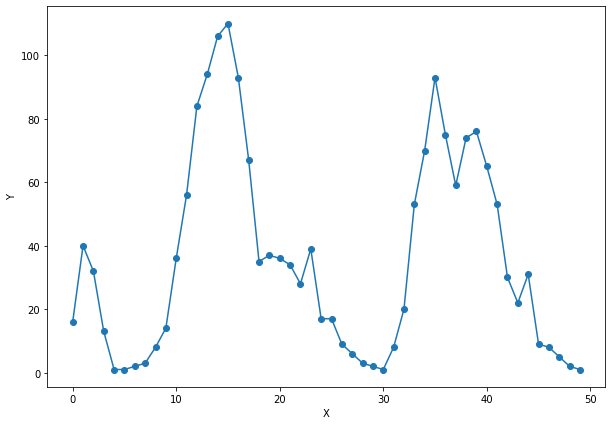

In [4]:
counts = rides['cnt'][:50]
x = np.arange(len(counts))
y = np.array(counts)

plt.figure(figsize = (10, 7))
plt.plot(x, y, 'o-')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 三、人工神经网络Neu

在这一小节中，我们将再构建一个人工神经网络，利用数据库中的星期几、节假日、时间、风速等信息预测共享单车的使用数量

该神经网络有56个输入层节点、10个隐含层节点和1个输出节点

### 1. 数据的预处理过程

要读入其他的数据就要考虑这些数据具有不同的数据类型以及取值范围，所以要对它们进行预处理

#### a. 对于类型变量的处理

有很多变量都属于类型变量，例如season=1,2,3,4，分四季。我们不能将season变量直接输入到神经网络，这是因为season数值越高并不表示相应的信号强度越大。我们的解决方案是将类型变量用一个“一位热码“（one-hot）来编码，也就是：

$
season = 1 \rightarrow (1, 0, 0 ,0) \\
season = 2 \rightarrow (0, 1, 0, 0) \\
season = 3 \rightarrow (0, 0, 1, 0) \\
season = 4 \rightarrow (0, 0, 0, 1) \\
$

因此，如果一个类型变量有n个不同取值，那么我们的“一位热码“所对应的向量长度就为n

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


#### b. 对于数值类型变量进行标准化
由于每个数值型变量都是相互独立的，所以它们的数值绝对大小与问题本身没有关系，为了消除数值大小的差异，我们对每一个数值型变量进行标准化处理，也就是让其数值都围绕着0左右波动。比如，对于温度temp这个变量来说，它在整个数据库取值的平均着为mean(temp), 方差为std(temp)，所以，归一化的温度计算为：

$ temp'=\frac{temp - mean(temp)}{std(temp)}$

这样做的好处就是可以将不同的取值范围的变量设置为让它们处于一个平等的地位。

In [6]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data[each] = (data[each] - mean) / std

In [7]:
print(data['temp'][0])

-1.3346091869412822


#### c. 将数据集进行分割

In [8]:
train_data = data[:-21*24]
test_data = data[-21*24:]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y), 1])
losses = []

训练数据： 16875 测试数据： 504


In [9]:
features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 2. 构建神经网络并进行训练
#### a. 手动编写用Tensor运算的人工神经网络

In [10]:
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
weights1 = torch.randn((input_size, hidden_size), dtype=torch.double, requires_grad=True)
biases1 = torch.randn((hidden_size,), dtype=torch.double, requires_grad=True)
weights2 = torch.randn((hidden_size, output_size), dtype=torch.double, requires_grad=True)

def neu(x):
    hidden = x.mm(weights1) + biases1.expand(x.size()[0], hidden_size)
    hidden = torch.sigmoid(hidden)
    output = hidden.mm(weights2)
    return output

def cost(x, y):
    error = torch.mean((x - y) ** 2)
    return error

def zero_grad():
    if weights1.grad is not None and biases1.grad is not None and weights2.grad is not None:
        weights1.grad.data.zero_()
        biases1.grad.data.zero_()
        weights2.grad.data.zero_()

def optimizer_step(learning_rate):
    weights1.data.add_(- learning_rate * weights1.grad.data)
    biases1.data.add_(- learning_rate * biases1.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

In [11]:
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype = torch.double, requires_grad=True)
        yy = torch.tensor(Y[start:end], dtype = torch.double, requires_grad=True)
        predict = neu(xx)
        loss = cost(predict, yy)
        zero_grad()
        loss.backward()
        optimizer_step(0.01)
        batch_loss.append(loss.data.numpy())
        
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 2.1057920589282175
100 0.4413729424818776
200 0.31372296425507357
300 0.27226825950397493
400 0.23797428479287858
500 0.2026059376438228
600 0.1695564297176549
700 0.14347540023824884
800 0.12357303596877958
900 0.10828925461959832


Text(0, 0.5, 'MSE')

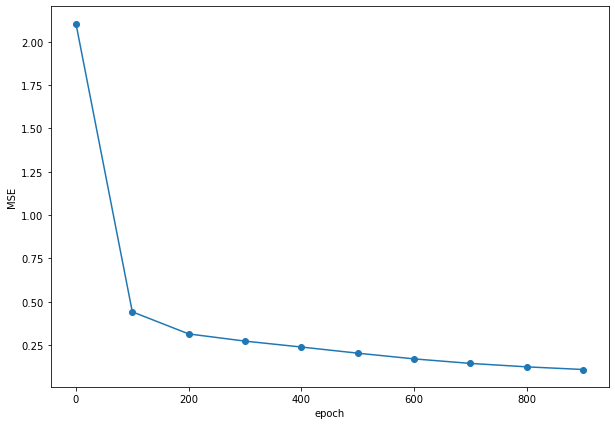

In [12]:
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses)) * 100, losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

#### b. 调用PyTorch现成的函数，构建序列化的神经网络

In [13]:
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr=0.01)

In [14]:
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y[start:end], dtype=torch.float, requires_grad=True)
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.9563231
100 0.2726391
200 0.23445474
300 0.1624767
400 0.10437715
500 0.08202859
600 0.0739901
700 0.06952395
800 0.06614788
900 0.06361067


Text(0, 0.5, 'MSE')

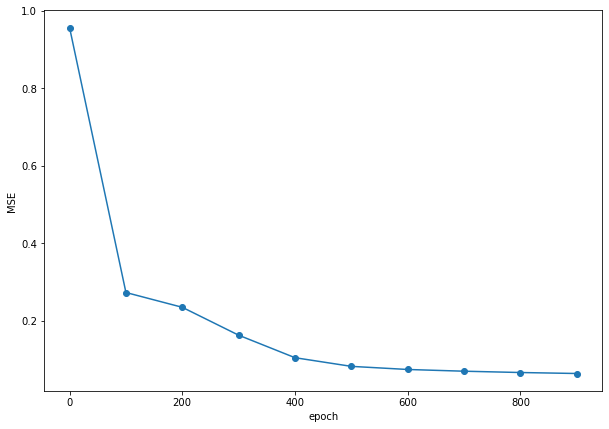

In [15]:
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

### 3. 测试神经网络

In [16]:
targets = test_targets['cnt'].values
targets = targets.reshape(len(targets), 1)
targets = targets.astype(float)

x = torch.tensor(test_features.values, dtype=torch.float, requires_grad=True)
y = torch.tensor(targets, dtype=torch.float, requires_grad=True)

predict = neu(x)
predict = predict.data.numpy()

189.46308763450142 181.38759909186473


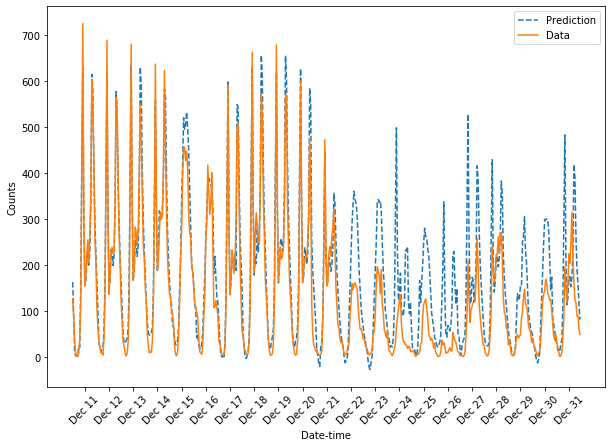

In [17]:
# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
print(mean, std)
ax.plot(predict * std + mean, label='Prediction', linestyle='--')
ax.plot(targets * std + mean, label='Data', linestyle='-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])# object->datetime
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### 4. 诊断网络*

在这一小节我们对网络出现的问题进行诊断，看看哪一些神经元导致了预测偏差

In [43]:
# 选出三天预测不准的日期：Dec 22，23，24
# 将这三天的数据聚集到一起，存入subset和subtargets中
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

# 将三个布尔型数组求或
bools = [any(tup) for tup in zip(bool1, bool2, bool3)]
# 将相应的变量取出来
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets), 1])

def feature(X, net):
    # 定义了一个函数可以提取网络的权重信息，所有的网络参数信息全部存储在了neu的named_parameters集合中
    X = torch.tensor(X, dtype=torch.float, requires_grad=False)
    dic = dict(net.named_parameters())
    weights = dic['0.weight']
    biases = dic['0.bias']
    # 计算隐含层结果并输出
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)]))
    return h

# 将这几天的数据输入到神经网络中，读取出隐含层神经元的激活数值，存入results中
results = feature(subset.values, neu).data.numpy()
# 这些数据对应的预测值（输出层）
predict = neu(torch.tensor(subset.values, dtype=torch.float, requires_grad=True)).data.numpy()

#将预测值还原成原始数据的数值范围
mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean

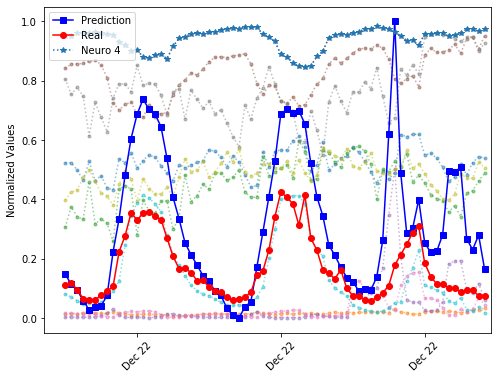

In [48]:
# 将所有的神经元激活水平画在同一张图上，蓝色的是模型预测的数值
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(results[:,:],".:",alpha=0.5) # 每个隐藏节点sigmoid输出画点虚线
ax.plot((predict - min(predict)) / (max(predict) - min(predict)),'bs-',label='Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)),'ro-',label='Real')
ax.plot(results[:, 3],':*',alpha=1, label='Neuro 4')

ax.set_xlim(right=len(predict))# 横轴显示范围
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])# 从22日第12小时开始，每24小时一个坐标点
_ = ax.set_xticklabels(dates[12:24], rotation=45)

Text(0, 0.5, 'Weight')

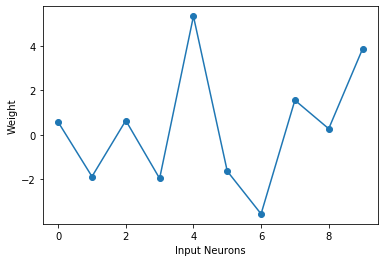

In [51]:
# 找到了与峰值响应的神经元，把它到输出层的权重输出出来
dic = dict(neu.named_parameters())
weights = dic['2.weight']
plt.plot(weights.data.numpy()[0],'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

Text(0, 0.5, 'Weight')

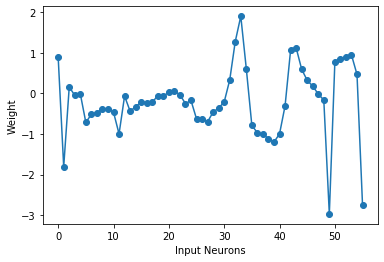

In [52]:
# 找到了峰值最高的第5个神经元，把它输入层的权重输出出来
dic = dict(neu.named_parameters())
weights = dic['0.weight'][4]
plt.plot(weights.data.numpy(),'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

In [53]:
# 列出所有的features中的数据列，找到对应的编号
for (i, c) in zip(range(len(features.columns)), features.columns):
    print(i, c)

0 yr
1 holiday
2 temp
3 hum
4 windspeed
5 season_1
6 season_2
7 season_3
8 season_4
9 weathersit_1
10 weathersit_2
11 weathersit_3
12 weathersit_4
13 mnth_1
14 mnth_2
15 mnth_3
16 mnth_4
17 mnth_5
18 mnth_6
19 mnth_7
20 mnth_8
21 mnth_9
22 mnth_10
23 mnth_11
24 mnth_12
25 hr_0
26 hr_1
27 hr_2
28 hr_3
29 hr_4
30 hr_5
31 hr_6
32 hr_7
33 hr_8
34 hr_9
35 hr_10
36 hr_11
37 hr_12
38 hr_13
39 hr_14
40 hr_15
41 hr_16
42 hr_17
43 hr_18
44 hr_19
45 hr_20
46 hr_21
47 hr_22
48 hr_23
49 weekday_0
50 weekday_1
51 weekday_2
52 weekday_3
53 weekday_4
54 weekday_5
55 weekday_6


## 4. 分类人工神经网络Neuc

本小节中，我们解决一个分类问题，即将预测数值根据大于或者小于预测数量的平均值来分成两类
我们只需要对Neuc进行小小的更改，将其输出单元数量设置为2，并加上Sigmoid函数就可以了

In [56]:
# 重新构造用于分类的人工神经网络Neuc

input_size = features.shape[1]
hidden_size = 10
output_size = 2
batch_size = 128
neuc = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Sigmoid(),
)
# 将损失函数定义为交叉熵
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(neuc.parameters(), lr = 0.1)

In [57]:
Y_labels = Y > np.mean(Y)
Y_labels = Y_labels.astype(int)
Y_labels = Y_labels.reshape(-1)
Y_labels

array([0, 0, 0, ..., 1, 1, 1])

In [58]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
    predictions = np.argmax(predictions, 1)
    return 100.0 - (
      100.0 *
      np.sum( predictions == labels) /
      predictions.shape[0])

# 神经网络训练循环
losses = []
errors = []
for i in range(4000):
    # 每128个样本点被划分为一个撮
    batch_loss = []
    batch_errors = []
    for start, end in zip(range(0, len(X), batch_size), range(batch_size, len(X)+1, batch_size)):
        xx = torch.tensor(X[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(Y_labels[start:end], dtype = torch.long)
        predict = neuc(xx)
        loss = cost(predict, yy)
        err = error_rate(predict.data.numpy(), yy.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        batch_errors.append(err)
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        errors.append(np.mean(batch_errors))
        print(i, np.mean(batch_loss), np.mean(batch_errors))

0 0.67128575 39.87356870229008
100 0.44291455 12.76240458015267
200 0.43370372 12.17199427480916
300 0.43099353 12.142175572519085
400 0.42459625 11.498091603053435
500 0.41310546 9.70300572519084
600 0.40239874 8.462547709923664
700 0.39267203 7.466603053435114
800 0.3855909 6.798664122137405
900 0.38084447 6.339456106870229
1000 0.37792474 6.071087786259542
1100 0.3757421 5.880248091603053
1200 0.37384766 5.653625954198473
1300 0.37212348 5.498568702290076
1400 0.3705746 5.385257633587786
1500 0.36919266 5.2958015267175576
1600 0.36795563 5.206345419847328
1700 0.36685506 4.9856870229007635
1800 0.36589065 4.8604484732824424
1900 0.36504987 4.735209923664122
2000 0.36431164 4.657681297709924
2100 0.363656 4.621898854961832
2200 0.3630674 4.538406488549619
2300 0.362533 4.502624045801527
2400 0.36204267 4.437022900763359
2500 0.36158788 4.413167938931298
2600 0.3611622 4.395276717557252
2700 0.36076036 4.35949427480916
2800 0.36037853 4.335639312977099
2900 0.3600149 4.281965648854962

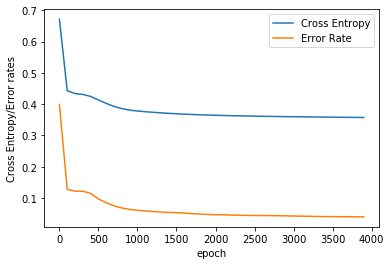

In [59]:
# 打印输出损失值
plt.plot(np.arange(len(losses))*100,losses, label = 'Cross Entropy')
plt.plot(np.arange(len(losses))*100, np.array(errors) / float(100), label = 'Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

对分类效果进行测试

error rate: 13.293650793650798


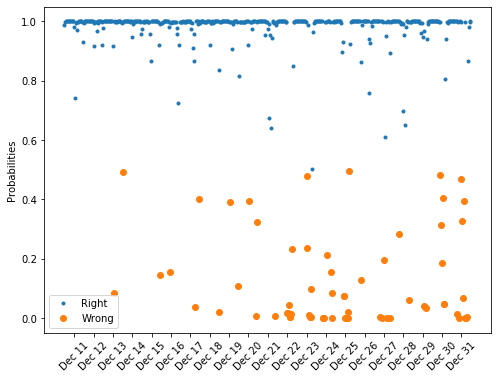

In [69]:
# 读取测试数据
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets), 1])
Y_labels = targets > np.mean(Y)
Y_labels = Y_labels.astype(int)
Y_labels = Y_labels.reshape(-1)
x = torch.tensor(test_features.values, dtype = torch.float, requires_grad = True)

# 打印神经网络预测的错误率
predict = neuc(x)
print("error rate:", error_rate(predict.data.numpy(), Y_labels))

# 接下来，我们把预测正确的数据和错误的数据分别画出来，纵坐标分别是预测正确的概率和预测错误的概率
prob = predict.data.numpy()
rights = np.argmax(prob, 1) == Y_labels
wrongs = np.argmax(prob, 1) != Y_labels
right_labels = Y_labels[rights]
wrong_labels = Y_labels[wrongs]
probs = prob[rights, :]
probs1 = prob[wrongs, :]
rightness = [probs[i, right_labels[i]] for i in range(len(right_labels))]
right_index = np.arange(len(targets))[rights]
wrongness = [probs1[i, wrong_labels[i]] for i in range(len(wrong_labels))]
wrong_index = np.arange(len(targets))[wrongs]
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(right_index, rightness, '.', label='Right')
ax.plot(wrong_index, wrongness,'o',label='Wrong')

ax.legend()
plt.ylabel('Probabilities')

dates = pd.to_datetime(rides.loc[test_features.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)